<a href="https://colab.research.google.com/github/srilamaiti/SM_MIDS_W207_HW/blob/main/w207_cancer_detection_sm_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import random
import joblib
import glob
import random
from imutils import rotate as rotate
from itertools import product
import gc
from sklearn.utils import shuffle
import cv2 as cv
import skimage.io as skio

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches
from matplotlib.patches import Polygon

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.python.ops.numpy_ops import np_config
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
np_config.enable_numpy_behavior()
from fastai.vision import *
from fastai.metrics import error_rate, accuracy

# Required to read the data from Kaggle
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Mounted at /content/gdrive


In [2]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.30G/6.31G [00:28<00:00, 211MB/s]
100% 6.31G/6.31G [00:28<00:00, 241MB/s]


In [3]:
!unzip -o -qq \*.zip  && rm *.zip

In [4]:
def generate_fully_qualified_file_name_list(file_list):
    """
    This function generates a list of fully qualified file names.
    """
    qualified_file_name_list = [os.path.join(current_working_dir, train_path) + 
                                img + 
                                '.tif' 
                                for img in file_list
                               ]
    return qualified_file_name_list

In [5]:
def get_id_and_label_list(file_path, file_extension):
    """
    This function gets the imgae id and corresponding label.
    """
    file_list = []
    for file_name in glob.glob(file_path + '*' + file_extension):
        file_list.append(file_name)
    return file_list

In [6]:
def split_data(split_indices, df):
    """
    This function splits the input dataframe in train, validation and test set.
    """
    X_train = df[: split_indices[0]]
    X_val = df[split_indices[0] : split_indices[1]]
    X_test = df[split_indices[1]:]
    return X_train, X_val, X_test

In [7]:
CONTRAST_FACTOR = 3
DELTA = 0.3

train_path = 'train/'
test_path = 'test/'

current_working_dir = os.getcwd()

train_label_file = 'train_labels.csv'
test_label_file = 'sample_submission.csv'

image_file_extension = '.tif'

train_files_path = os.path.join(current_working_dir, train_path)
test_files_path = os.path.join(current_working_dir, test_path)

# declare constants for reproduciblity
RANDOM_STATE = 20220922

# Finding split positions
split = (0.30, 0.10, 0.10)

process_chunk_size = 200
zoom_range = (0.4, 0.5)

tf.random.set_seed(1234)
np.random.seed(1234)

In [8]:
#get file names for train and test
train_file_list = []
test_file_list = []

train_file_list = get_id_and_label_list(train_files_path, image_file_extension)
test_file_list = get_id_and_label_list(test_files_path, image_file_extension)

train_label = pd.read_csv(train_label_file)
test_label = pd.read_csv(test_label_file)

print(f"Number of train files : {len(train_file_list)}")
print(f"Number of test files : {len(test_file_list)}")

Number of train files : 220025
Number of test files : 57458


In [9]:
train_positive_image_id_list = list(train_label[train_label.label==1].id)
train_negative_image_id_list = list(train_label[train_label.label==0].id)

train_positive_images_list = generate_fully_qualified_file_name_list(train_positive_image_id_list)
train_negative_images_list = generate_fully_qualified_file_name_list(train_negative_image_id_list)

print(f"Number of positive images in train set: {len(train_positive_images_list)}")
print(f"Number of negative images in train set: {len(train_negative_images_list)}")

Number of positive images in train set: 89117
Number of negative images in train set: 130908


In [10]:
# Shuffling data
shuffled_train_label = shuffle(train_label)
len_shuffled_train_label = len(shuffled_train_label)

# Selecting positive and negative images from the shuffled list
shuffled_train_positive_label_df = shuffled_train_label[shuffled_train_label.label == 1]
shuffled_train_negative_label_df = shuffled_train_label[shuffled_train_label.label == 0]

print(f"Length of shuffled_train_positive_label_df : {len(shuffled_train_positive_label_df)}")
print(f"Length of shuffled_train_negative_label_df : {len(shuffled_train_negative_label_df)}")

Length of shuffled_train_positive_label_df : 89117
Length of shuffled_train_negative_label_df : 130908


In [11]:
split_indices = np.multiply(len(shuffled_train_positive_label_df), split).astype(int)
for idx, val in enumerate(split_indices):
    #print(idx, val)
    if idx > 0:
        split_indices[idx] = sum(split_indices[idx - 1 : idx]) + split_indices[idx]
print("Split indecs : ", split_indices)

Split indecs :  [26735 35646 44557]


In [12]:
# Splitting data at train, validation and test positions 
# for both positive and negative imgaes
# This process will select the list of ids
(X_train_id_positive, 
 X_val_id_positive, 
 X_test_id_positive) = split_data(split_indices = split_indices, 
                                  df = shuffled_train_positive_label_df[:split_indices[-1]]
                                 )
(X_train_id_negative, 
 X_val_id_negative, 
 X_test_id_negative) = split_data(split_indices = split_indices, 
                                  df = shuffled_train_negative_label_df[:split_indices[-1]]
                                 )
 
print(f"Length of X_train_id_positive : {len(X_train_id_positive)}")
print(f"Length of X_train_id_negative : {len(X_train_id_negative)}")

print(f"Length of X_val_id_positive : {len(X_val_id_positive)}")
print(f"Length of X_val_id_negative : {len(X_val_id_negative)}")

print(f"Length of X_test_id_positive : {len(X_test_id_positive)}")
print(f"Length of X_test_id_negative : {len(X_test_id_negative)}")

Length of X_train_id_positive : 26735
Length of X_train_id_negative : 26735
Length of X_val_id_positive : 8911
Length of X_val_id_negative : 8911
Length of X_test_id_positive : 8911
Length of X_test_id_negative : 8911


In [13]:
X_train_img_file_positive = generate_fully_qualified_file_name_list(list(np.concatenate(X_train_id_positive[['id']].values.tolist()).flat))
X_val_img_file_positive = generate_fully_qualified_file_name_list(list(np.concatenate(X_val_id_positive[['id']].values.tolist()).flat))
X_test_img_file_positive = generate_fully_qualified_file_name_list(list(np.concatenate(X_test_id_positive[['id']].values.tolist()).flat))

X_train_img_file_negative = generate_fully_qualified_file_name_list(list(np.concatenate(X_train_id_negative[['id']].values.tolist()).flat))
X_val_img_file_negative = generate_fully_qualified_file_name_list(list(np.concatenate(X_val_id_negative[['id']].values.tolist()).flat))
X_test_img_file_negative = generate_fully_qualified_file_name_list(list(np.concatenate(X_test_id_negative[['id']].values.tolist()).flat))

print(f"Length of X_train_img_file_positive : {len(X_train_img_file_positive)}")
print(f"Length of X_train_img_file_negative : {len(X_train_img_file_negative)}")

print(f"Length of X_val_img_file_positive : {len(X_val_img_file_positive)}")
print(f"Length of X_val_img_file_negative : {len(X_val_img_file_negative)}")

print(f"Length of X_test_img_file_positive : {len(X_test_img_file_positive)}")
print(f"Length of X_test_img_file_negative : {len(X_test_img_file_negative)}")

Length of X_train_img_file_positive : 26735
Length of X_train_img_file_negative : 26735
Length of X_val_img_file_positive : 8911
Length of X_val_img_file_negative : 8911
Length of X_test_img_file_positive : 8911
Length of X_test_img_file_negative : 8911


In [14]:
!rm -rf /content/image_processing 
!mkdir /content/image_processing
!mkdir /content/image_processing/train /content/image_processing/test /content/image_processing/validation
!mkdir /content/image_processing/train/positive /content/image_processing/train/negative
!mkdir /content/image_processing/test/positive /content/image_processing/test/negative
!mkdir /content/image_processing/validation/positive /content/image_processing/validation/negative

In [15]:
image_processing_train_positive_path = '/content/image_processing/train/positive'
image_processing_train_negative_path = '/content/image_processing/train/negative'

image_processing_validation_positive_path = '/content/image_processing/validation/positive'
image_processing_validation_negative_path = '/content/image_processing/validation/negative'

image_processing_test_positive_path = '/content/image_processing/test/positive'
image_processing_test_negative_path = '/content/image_processing/test/negative'

In [16]:
def move_file_from_one_to_other(file_names, dest_path):
    command = 'cp -r ' + file_names + ' ' + dest_path
    #print(command)
    os.system(command)

In [17]:
def process_move_files(file_name_list, dest_path):
    """"
    This function moves the files to a destination directory
    """
    process_chunk_size = 10
    for idx in range(0, len(file_name_list), process_chunk_size):
        #print("a")
        if idx % 1000 == 0:
            print("Processing index: ", idx)
        #print('b')
        file_names = ' '.join(file_name_list[idx : idx + process_chunk_size])
        #print('c')
        move_file_from_one_to_other(file_names, dest_path)

In [18]:
process_move_files(X_train_img_file_positive, image_processing_train_positive_path)
process_move_files(X_train_img_file_negative, image_processing_train_negative_path)

process_move_files(X_val_img_file_positive, image_processing_validation_positive_path)
process_move_files(X_val_img_file_negative, image_processing_validation_negative_path)

process_move_files(X_test_img_file_positive, image_processing_test_positive_path)
process_move_files(X_test_img_file_negative, image_processing_test_negative_path)


Processing index:  0
Processing index:  1000
Processing index:  2000
Processing index:  3000
Processing index:  4000
Processing index:  5000
Processing index:  6000
Processing index:  7000
Processing index:  8000
Processing index:  9000
Processing index:  10000
Processing index:  11000
Processing index:  12000
Processing index:  13000
Processing index:  14000
Processing index:  15000
Processing index:  16000
Processing index:  17000
Processing index:  18000
Processing index:  19000
Processing index:  20000
Processing index:  21000
Processing index:  22000
Processing index:  23000
Processing index:  24000
Processing index:  25000
Processing index:  26000
Processing index:  0
Processing index:  1000
Processing index:  2000
Processing index:  3000
Processing index:  4000
Processing index:  5000
Processing index:  6000
Processing index:  7000
Processing index:  8000
Processing index:  9000
Processing index:  10000
Processing index:  11000
Processing index:  12000
Processing index:  13000
P

In [19]:
total_train = len(X_train_img_file_positive) + len(X_train_img_file_negative)
total_val = len(X_val_img_file_positive) + len(X_val_img_file_negative)

In [21]:
BATCH_SIZE = 100
IMG_SHAPE = 96

In [23]:
train_dir = '/content/image_processing/train/'
val_dir = '/content/image_processing/validation/'
test_dir = '/content/image_processing/test/'

In [24]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 53470 images belonging to 2 classes.


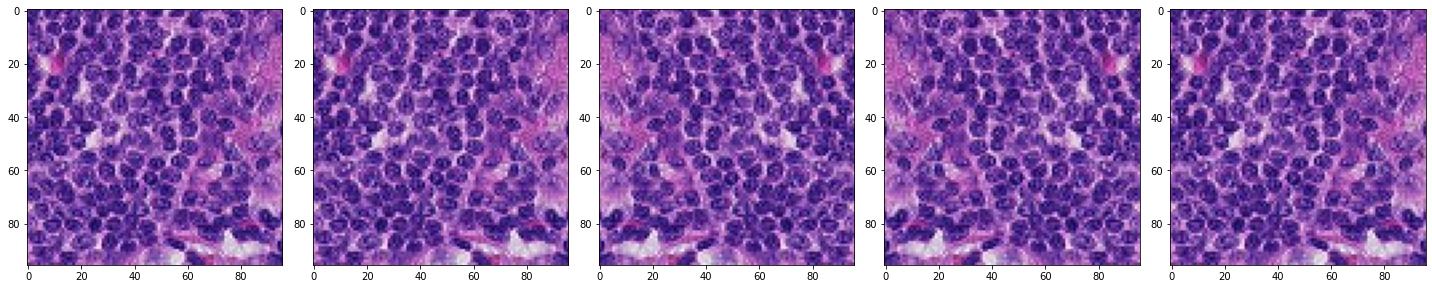

In [25]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [26]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

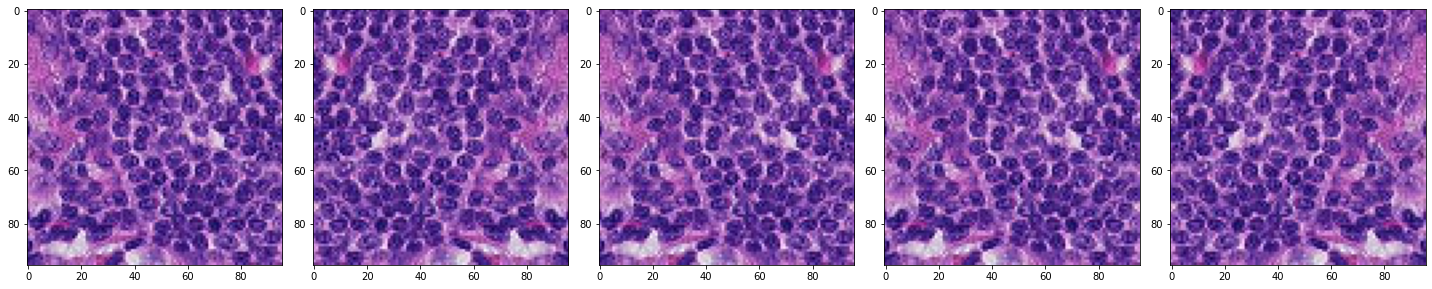

In [27]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [28]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=90,
      width_shift_range=0.15,
      height_shift_range=0.15,
      #shear_range=0.2,
      zoom_range=0.5,
      horizontal_flip=False,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='sparse')

Found 53470 images belonging to 2 classes.


In [29]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 17822 images belonging to 2 classes.


In [30]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [31]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=80
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/80
179/535 [=========>....................] - ETA: 2:01 - loss: 0.5927 - accuracy: 0.6524

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()